In [23]:

import requests as rq
import networkx as nx
from networkx.readwrite import json_graph

topo_graph_ryu = json_graph.node_link_graph(
    rq.get('http://localhost:8080/topology_graph').json())

topo_graph = json_graph.node_link_graph(
    rq.get('http://0.0.0.0:8000/graph').json())

host_mn = rq.get('http://0.0.0.0:8000/host').json()
switch_dpid_mn = rq.get('http://0.0.0.0:8000/switch_dpid')

links_info = rq.get('http://localhost:8000/link_info').json()
li_map = {}
for d in links_info:
    key = (d['node1'], d['node2'])
    key2 = (d['node2'], d['node1'])
    li_map[key] = d
    li_map[key2] = d.copy()
    li_map[key2]['node1'], li_map[key2]['node2'] = li_map[key2]['node2'], li_map[key2]['node1']
    li_map[key2]['port1'], li_map[key2]['port2'] = li_map[key2]['port2'], li_map[key2]['port1']
li_map
# links_info

{('s1', 'h1'): {'max_queue_size': 1000,
  'use_htb': True,
  'node1': 's1',
  'node2': 'h1',
  'port1': 1,
  'port2': 0},
 ('h1', 's1'): {'max_queue_size': 1000,
  'use_htb': True,
  'node1': 'h1',
  'node2': 's1',
  'port1': 0,
  'port2': 1},
 ('s1', 'h1000'): {'max_queue_size': 1000,
  'use_htb': True,
  'node1': 's1',
  'node2': 'h1000',
  'port1': 2,
  'port2': 0},
 ('h1000', 's1'): {'max_queue_size': 1000,
  'use_htb': True,
  'node1': 'h1000',
  'node2': 's1',
  'port1': 0,
  'port2': 2},
 ('s1', 's2'): {'bw': 139,
  'delay': '39ms',
  'loss': 2,
  'max_queue_size': 1000,
  'use_htb': True,
  'node1': 's1',
  'node2': 's2',
  'port1': 3,
  'port2': 3},
 ('s2', 's1'): {'bw': 139,
  'delay': '39ms',
  'loss': 2,
  'max_queue_size': 1000,
  'use_htb': True,
  'node1': 's2',
  'node2': 's1',
  'port1': 3,
  'port2': 3},
 ('s1', 's3'): {'bw': 91,
  'delay': '54ms',
  'loss': 2,
  'max_queue_size': 1000,
  'use_htb': True,
  'node1': 's1',
  'node2': 's3',
  'port1': 4,
  'port2': 3},


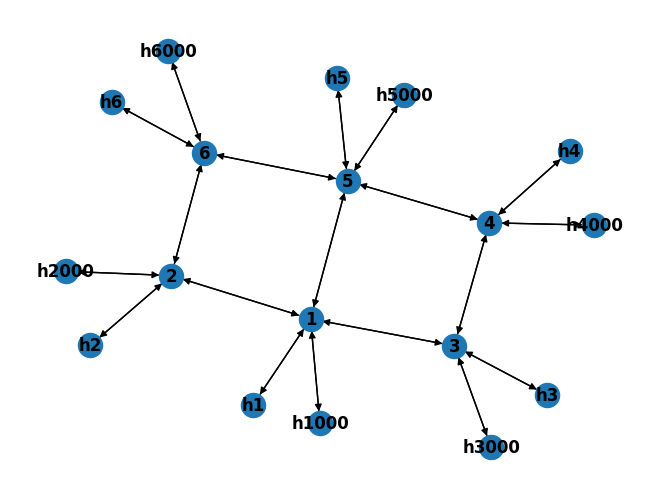

In [24]:
import matplotlib.pyplot as plt

nx.draw(topo_graph, with_labels=True, font_weight='bold')
plt.show()

In [104]:
# list(topo_graph.nodes)
host_mn

{'h1': {'mac': '00:00:00:00:00:01', 'ip': '10.0.0.1'},
 'h2': {'mac': '00:00:00:00:00:02', 'ip': '10.0.0.2'},
 'h3': {'mac': '00:00:00:00:00:03', 'ip': '10.0.0.3'},
 'h4': {'mac': '00:00:00:00:00:04', 'ip': '10.0.0.4'},
 'h5': {'mac': '00:00:00:00:00:05', 'ip': '10.0.0.5'},
 'h6': {'mac': '00:00:00:00:00:06', 'ip': '10.0.0.6'},
 'h1000': {'mac': '00:00:00:00:03:e8', 'ip': '10.0.0.7'},
 'h2000': {'mac': '00:00:00:00:07:d0', 'ip': '10.0.0.8'},
 'h3000': {'mac': '00:00:00:00:0b:b8', 'ip': '10.0.0.9'},
 'h4000': {'mac': '00:00:00:00:0f:a0', 'ip': '10.0.0.10'},
 'h5000': {'mac': '00:00:00:00:13:88', 'ip': '10.0.0.11'},
 'h6000': {'mac': '00:00:00:00:17:70', 'ip': '10.0.0.12'}}

In [26]:
def min_hop(graph, src_host, dst_host):
    solutions = {'route': []}
    flowrules = []
    if nx.has_path(graph, f'h{src_host}', f'h{dst_host}'):
        path = list(nx.shortest_path(graph,
                                     f'h{src_host}',
                                     f'h{dst_host}'))
        
        solutions['route'].append({
            'src_host': src_host,
            'dst_host': dst_host,
            'path_dpid': path[1:-1],
        })
    return solutions
    
solution = min_hop(topo_graph, '1', '3')

In [29]:
def flowrule_template(dpid, in_port, out_port, hostmac_src, hostmac_dst, priority=1):
    return {
        "dpid": dpid,
        "cookie": 1,
        "cookie_mask": 1,
        "table_id": 0,
        "idle_timeout": 3000,
        "hard_timeout": 3000,
        "priority": priority,
        "flags": 1,
        "match": {
            "in_port": in_port,
            "dl_src": hostmac_src,
            "dl_dst": hostmac_dst,
        },
        "actions": [{
            "type": "OUTPUT",
            "port": out_port,
        }]
    }

def create_flowrule_multidomain_json(solutions, host_json_mn,
                                     links_info, important=False):
    flowrules = []
    
    for solution in solutions['route']:
        path_dpid = [int(dpid) for dpid in solution['path_dpid']]
        hostmac_src = host_json_mn[f'h{solution["src_host"]}']['mac']
        hostmac_dst = host_json_mn[f'h{solution["dst_host"]}']['mac']
        print('endpoint info' , hostmac_src, hostmac_dst)
        
        if (hostmac_src or hostmac_dst) == None or hostmac_src == hostmac_dst:
            raise (ValueError("invaild host mac"))
        
        src_endpoint_port = links_info[(f'h{solution["src_host"]}',
                                        f's{path_dpid[0]}')]['port2']
        dst_endpoint_port = links_info[(f's{path_dpid[-1]}',
                                        f'h{solution["dst_host"]}')]['port1']
        
        dpid_flowport = {
            'eth_src': hostmac_src,
            'eth_dst': hostmac_dst,
            'dpid_path': [],
            'port_pair_path': []
        }
        
        for i in range(len(path_dpid)-1):
            # start
            if i == 0:
                in_port = src_endpoint_port
                out_port = links_info[(f's{path_dpid[i]}',
                                      f's{path_dpid[i+1]}')]['port1']
                # print(f'start {i}')
                # print(in_port, out_port)
                dpid_flowport['dpid_path'].append(path_dpid[i])
                dpid_flowport['port_pair_path'].append([in_port, out_port])
                            
            # inbetween
            if i > 0 and i <= len(path_dpid)-2:
                # print(f'inbetween: {i}')
                # ra o dau nay thi vao o dau kia
                in_port = links_info[(f's{path_dpid[i-1]}',
                                      f's{path_dpid[i]}')]['port2']        
                out_port = links_info[(f's{path_dpid[i]}', 
                                       f's{path_dpid[i+1]}')]['port1']
                dpid_flowport['dpid_path'].append(path_dpid[i])
                dpid_flowport['port_pair_path'].append([in_port, out_port])
                # print(in_port, out_port)
            
            # finish
            if i >= len(path_dpid)-2:
                # print(f'finish {i+1}')
                in_port = links_info[(f's{path_dpid[i]}',
                                      f's{path_dpid[i+1]}')]['port2']
                print('a',out_port)
                out_port = dst_endpoint_port
                print('b', out_port)
                
                # +1 for -2
                dpid_flowport['dpid_path'].append(path_dpid[i+1])
                dpid_flowport['port_pair_path'].append([in_port, out_port])
                # print(in_port, out_port)

        # create bi-directional flowrule
        for dpid, port_pair in zip(dpid_flowport['dpid_path'], dpid_flowport['port_pair_path']):
            flowrules.append(flowrule_template(dpid, port_pair[0], port_pair[1], hostmac_src, hostmac_dst))
            flowrules.append(flowrule_template(dpid, port_pair[1], port_pair[0], hostmac_dst, hostmac_src))

    return flowrules
        
create_flowrule_multidomain_json(solution, host_mn, li_map)

endpoint info 00:00:00:00:00:01 00:00:00:00:00:03
a 4
b 1


[{'dpid': 1,
  'cookie': 1,
  'cookie_mask': 1,
  'table_id': 0,
  'idle_timeout': 3000,
  'hard_timeout': 3000,
  'priority': 1,
  'flags': 1,
  'match': {'in_port': 1,
   'dl_src': '00:00:00:00:00:01',
   'dl_dst': '00:00:00:00:00:03'},
  'actions': [{'type': 'OUTPUT', 'port': 4}]},
 {'dpid': 1,
  'cookie': 1,
  'cookie_mask': 1,
  'table_id': 0,
  'idle_timeout': 3000,
  'hard_timeout': 3000,
  'priority': 1,
  'flags': 1,
  'match': {'in_port': 4,
   'dl_src': '00:00:00:00:00:03',
   'dl_dst': '00:00:00:00:00:01'},
  'actions': [{'type': 'OUTPUT', 'port': 1}]},
 {'dpid': 3,
  'cookie': 1,
  'cookie_mask': 1,
  'table_id': 0,
  'idle_timeout': 3000,
  'hard_timeout': 3000,
  'priority': 1,
  'flags': 1,
  'match': {'in_port': 3,
   'dl_src': '00:00:00:00:00:01',
   'dl_dst': '00:00:00:00:00:03'},
  'actions': [{'type': 'OUTPUT', 'port': 1}]},
 {'dpid': 3,
  'cookie': 1,
  'cookie_mask': 1,
  'table_id': 0,
  'idle_timeout': 3000,
  'hard_timeout': 3000,
  'priority': 1,
  'flags': 1

In [13]:
import requests as rq
flowrules =  [
    {
        "dpid": 2,
        "cookie": 1,
        "cookie_mask": 1,
        "table_id": 0,
        "idle_timeout": 3000,
        "hard_timeout": 3000,
        "priority": 3000,
        "flags": 1,
        "match": {
            "in_port": 1,
            "dl_src": '00:00:00:00:00:02',
            "dl_dst": '00:00:00:00:00:03',
        },
        "actions": [{
            "type": "OUTPUT",
            "port": 3,
        }]
    },
    {
        "dpid": 2,
        "cookie": 1,
        "cookie_mask": 1,
        "table_id": 0,
        "idle_timeout": 3000,
        "hard_timeout": 3000,
        "priority": 3000,
        "flags": 1,
        "match": {
            "in_port": 3,
            "dl_src": '00:00:00:00:00:03',
            "dl_dst": '00:00:00:00:00:02',
        },
        "actions": [{
            "type": "OUTPUT",
            "port": 1,
        }]
    },
    {
        "dpid": 3,
        "cookie": 1,
        "cookie_mask": 1,
        "table_id": 0,
        "idle_timeout": 3000,
        "hard_timeout": 3000,
        "priority": 3000,
        "flags": 1,
        "match": {
            "in_port": 1,
            "dl_src": '00:00:00:00:00:03',
            "dl_dst": '00:00:00:00:00:02',
        },
        "actions": [{
            "type": "OUTPUT",
            "port": 2,
        }]
    },
    {
        "dpid": 3,
        "cookie": 1,
        "cookie_mask": 1,
        "table_id": 0,
        "idle_timeout": 3000,
        "hard_timeout": 3000,
        "priority": 3000,
        "flags": 1,
        "match": {
            "in_port": 2,
            "dl_src": '00:00:00:00:00:02',
            "dl_dst": '00:00:00:00:00:03',
        },
        "actions": [{
            "type": "OUTPUT",
            "port": 1,
        }]
    },
]

import json

for flowrule in flowrules[0:2]:
    result1 = rq.post(
        f'http://0.0.0.0:8080/stats/flowentry/add', 
        data=json.dumps(flowrule))
    
for flowrule in flowrules[2:4]:
    result1 = rq.post(
        f'http://0.0.0.0:8081/stats/flowentry/add', 
        data=json.dumps(flowrule))

In [9]:
import requests as rq
flowrules =  [
    {
        "dpid": 1,
        "cookie": 1,
        "cookie_mask": 1,
        "table_id": 0,
        "idle_timeout": 3000,
        "hard_timeout": 3000,
        "priority": 3000,
        "flags": 1,
        "match": {
            "in_port": 1,
            "dl_src": '00:00:00:00:00:01',
            "dl_dst": '00:00:00:00:00:02',
        },
        "actions": [{
            "type": "OUTPUT",
            "port": 2,
        }]
    },
    {
        "dpid": 1,
        "cookie": 1,
        "cookie_mask": 1,
        "table_id": 0,
        "idle_timeout": 3000,
        "hard_timeout": 3000,
        "priority": 3000,
        "flags": 1,
        "match": {
            "in_port": 2,
            "dl_src": '00:00:00:00:00:02',
            "dl_dst": '00:00:00:00:00:01',
        },
        "actions": [{
            "type": "OUTPUT",
            "port": 1,
        }]
    },
        {
        "dpid": 2,
        "cookie": 1,
        "cookie_mask": 1,
        "table_id": 0,
        "idle_timeout": 3000,
        "hard_timeout": 3000,
        "priority": 3000,
        "flags": 1,
        "match": {
            "in_port": 1,
            "dl_src": '00:00:00:00:00:02',
            "dl_dst": '00:00:00:00:00:01',
        },
        "actions": [{
            "type": "OUTPUT",
            "port": 2,
        }]
    },
    {
        "dpid": 2,
        "cookie": 1,
        "cookie_mask": 1,
        "table_id": 0,
        "idle_timeout": 3000,
        "hard_timeout": 3000,
        "priority": 3000,
        "flags": 1,
        "match": {
            "in_port": 2,
            "dl_src": '00:00:00:00:00:01',
            "dl_dst": '00:00:00:00:00:02',
        },
        "actions": [{
            "type": "OUTPUT",
            "port": 1,
        }]
    },
]

import json

for flowrule in flowrules:
    result1 = rq.post(
        f'http://0.0.0.0:8080/stats/flowentry/add', 
        data=json.dumps(flowrule))

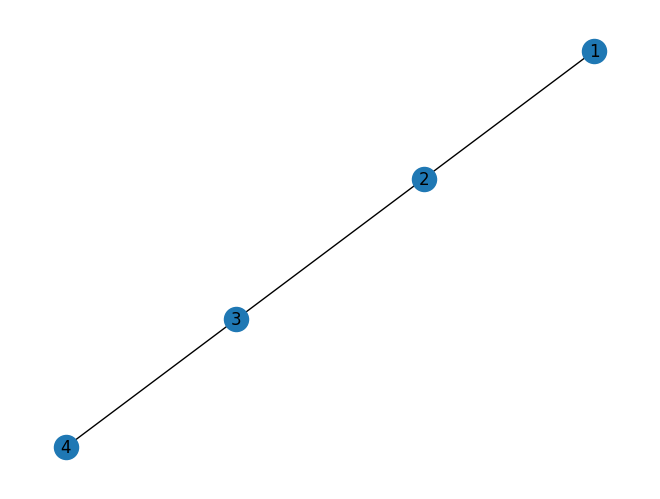

In [17]:
import networkx as nx

# Create an empty graph
G = nx.Graph()

# Add 4 nodes to the graph
G.add_nodes_from([1, 2, 3, 4])

# Add edges to create a linear graph
G.add_edges_from([(1, 2), (2, 3), (3, 4)])

# Save graph
nx.write_graphml_lxml(G, "4s.graphml")

# Draw the graph using a layout suitable for linear graphs
nx.draw(G, with_labels=True)

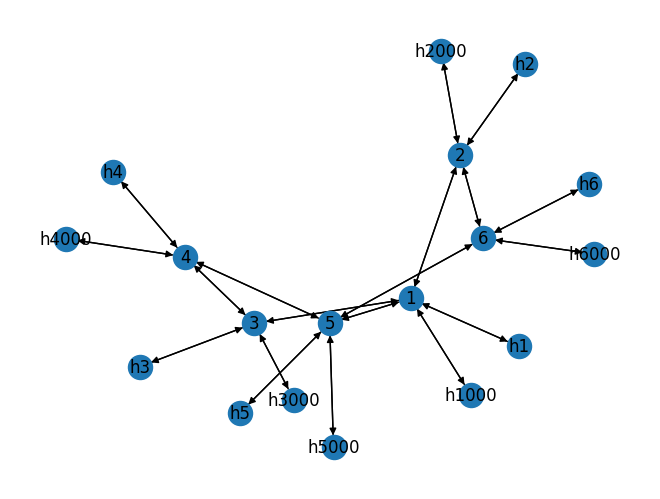

In [31]:
import requests as rq
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt
graph = rq.get('http://0.0.0.0:8000/graph').json()
nx.draw(json_graph.node_link_graph(graph), with_labels=True)